# 1. Project Overview

### *Project Description*

This project looks to develop an algorithm to identify metastatic cancer in small image patches extracted from larger digital pathology scans. The dataset used is a modified version of the PatchCamelyon (PCam) benchmark dataset, which focuses on the detection of metastasis in cancer patients.

The primary problem that this project aims to solve is the automated identification of metastatic cancer in digital pathology images. This will be done by creating deep learning models that can accurately classify whether a given image patch contains evidence of cancer metastasis or not.

### *Dataset Description*

The dataset consists of a large number of small pathology images to classify. Files are named with an image `id`. The `train_labels.csv` file provides the ground truth for the images in the `train` folder. We are predicting the labels for the images in the `test` folder. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable fully-convolutional models that do not use zero-padding, to ensure consistent behavior when applied to a whole-slide image.

The original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates. Otherwise, the dataset maintains the same data and splits as the PCam benchmark.

---

# 2. Project Setup

In [1]:
# SUPPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

In [2]:
# IMPORT LIBRARIES
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2

from PIL import Image, ImageDraw

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

In [3]:
# SET NOTEBOOK FORMATTING OPTIONS
pd.options.display.float_format = '{:.4f}'.format
%matplotlib inline
plt.rcParams['figure.figsize'] = [8, 5]

In [4]:
# READ IN DATA
train_labels_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv') # Training Labels

---

# 3. Exploratory Data Analysis (EDA)

In [5]:
# Preview training labels
display(train_labels_df)

id  label
0       f38a6374c348f90b587e046aac6079959adf3835      0
1       c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2       755db6279dae599ebb4d39a9123cce439965282d      0
3       bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4       068aba587a4950175d04c680d38943fd488d6a9d      0
...                                          ...    ...
220020  53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6      0
220021  d4b854fe38b07fe2831ad73892b3cec877689576      1
220022  3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75      0
220023  f129691c13433f66e1e0671ff1fe80944816f5a2      0
220024  a81f84895ddcd522302ddf34be02eb1b3e5af1cb      1

[220025 rows x 2 columns]

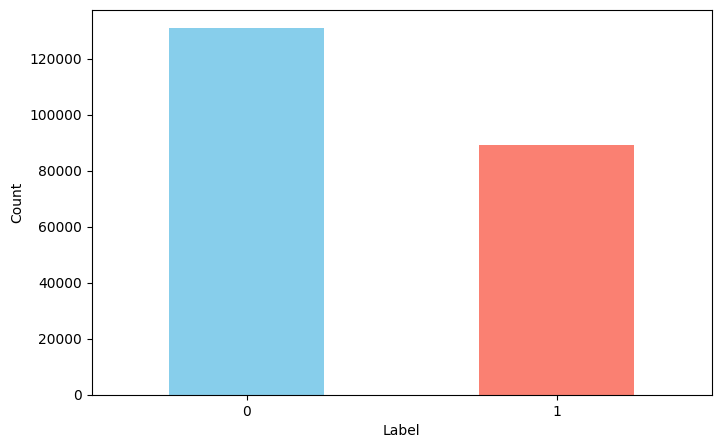

In [6]:
# Plot distribution of labels
train_labels_df['label'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
# Non-cancerous tissue image labels
neg_img_labels = train_labels_df[train_labels_df['label'] == 0]['id'].values

# Cancerous tissue image labels
pos_img_labels = train_labels_df[train_labels_df['label'] == 1]['id'].values

In [8]:
# Function for plotting tissue images
def plot_img(ids,title,nrows=5,ncols=15):

    fig,ax = plt.subplots(nrows,ncols,figsize=(18,6))
    plt.subplots_adjust(wspace=0, hspace=0) 
    for i,j in enumerate(ids[:nrows*ncols]):
        fname = os.path.join('../input/histopathologic-cancer-detection/train/',j +'.tif')
        img = Image.open(fname)
        idcol = ImageDraw.Draw(img)
        idcol.rectangle(((0,0),(95,95)),outline='white')
        plt.subplot(nrows, ncols, i+1) 
        plt.imshow(np.array(img))
        plt.axis('off')

    plt.suptitle(title, y=0.94)

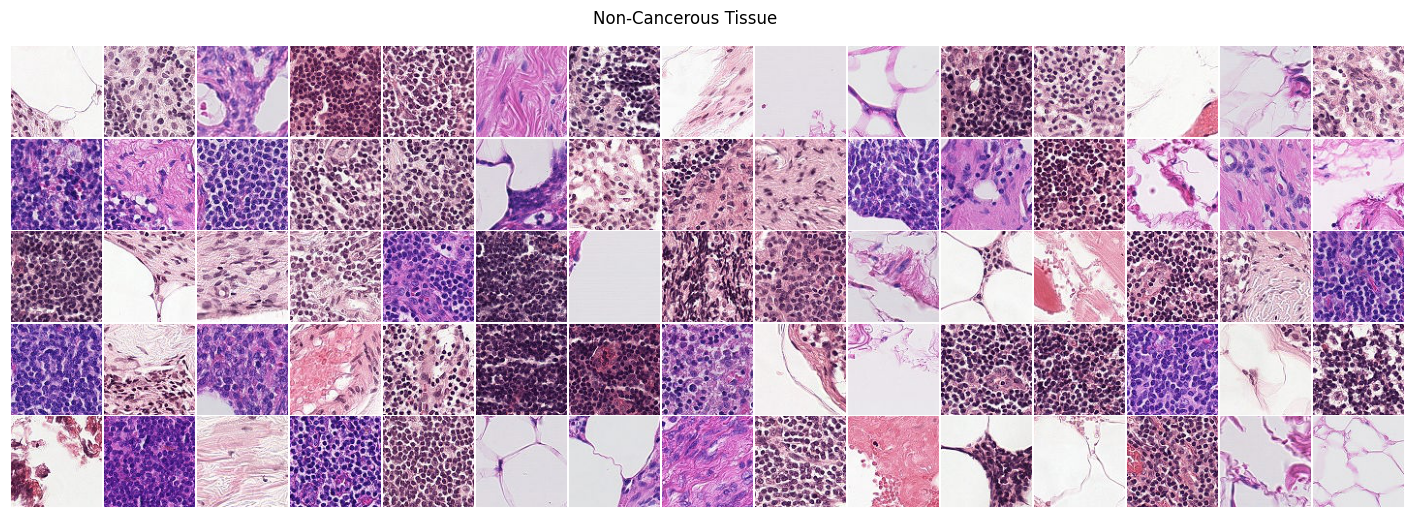

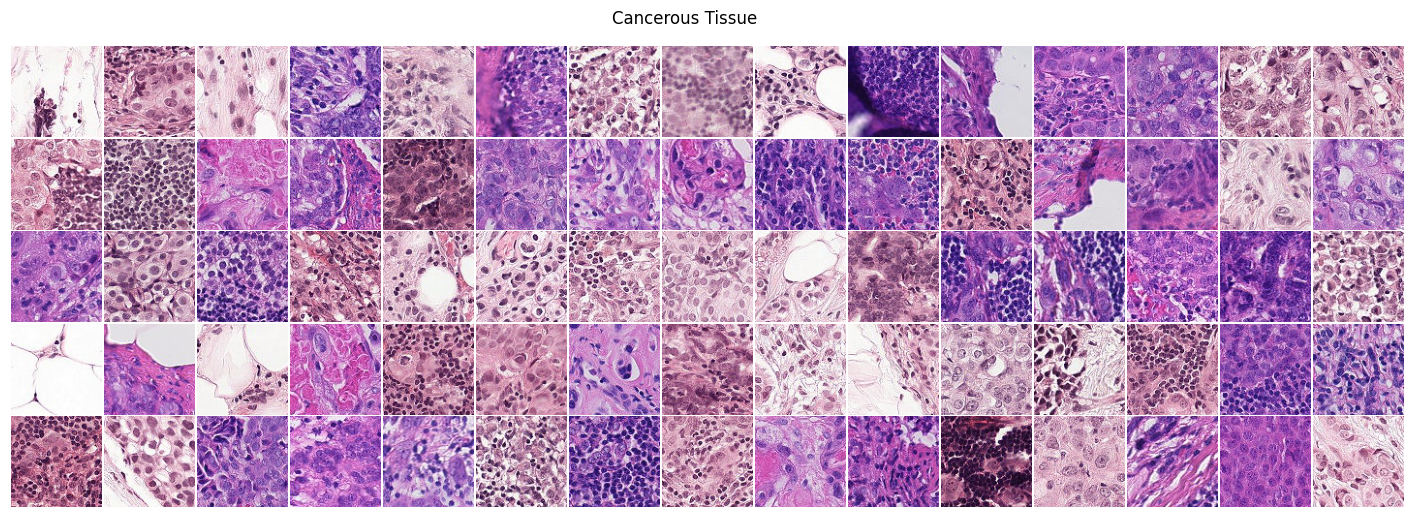

In [9]:
plot_img(neg_img_labels, "Non-Cancerous Tissue")
plot_img(pos_img_labels, "Cancerous Tissue")

## **3.1 Image Resizing**
Resize images to 96x96 pixels.

In [10]:
IMG_WIDTH, IMG_HEIGHT = 96, 96

def resize_image(img_path, target_width=IMG_WIDTH, target_height=IMG_HEIGHT):
    img = load_img(img_path, target_size=(target_width, target_height))
    return img_to_array(img)

sample_path = train_labels_df['id'].iloc[0]
img_resized = resize_image(f'../input/histopathologic-cancer-detection/train/{sample_path}.tif')

print(f"Resized Image Shape: {img_resized.shape}")

Resized Image Shape: (96, 96, 3)


## **3.2 Normalization**
Normalize pixel values to fall betwen 0 and 1.

In [11]:
def normalize_image(img):
    return img / 255.0

normalized_img = normalize_image(img_resized)

print(f"Normalized Image Pixel Range: {np.min(normalized_img)} - {np.max(normalized_img)}")

Normalized Image Pixel Range: 0.0 - 1.0


## **3.3 Data Splitting**
Split data into training (80%), validation (10%), and test (10%) sets.

In [12]:
train_data, temp_data, train_labels, temp_labels = train_test_split(train_labels_df['id'].values, train_labels_df['label'].values, test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

## **3.4 Data Augmentation**
Augment data to increase the diversity of the training data and prevent overfitting.

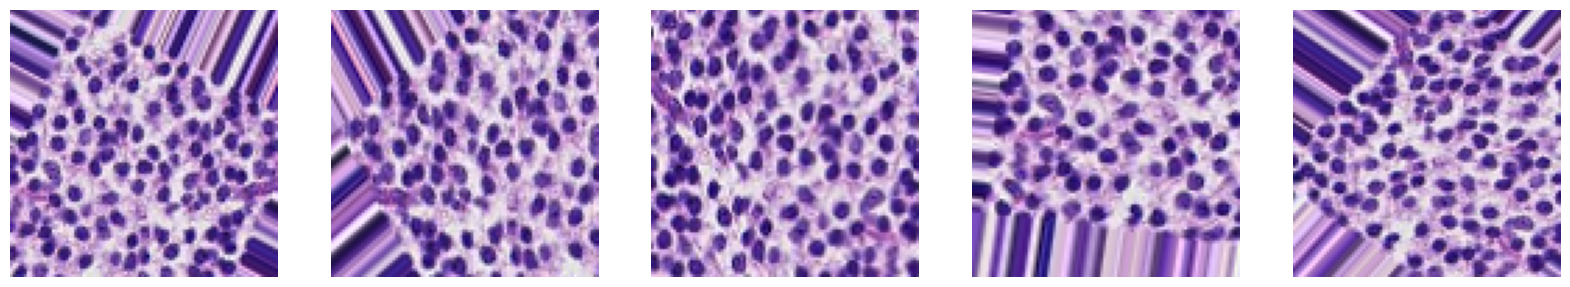

In [13]:
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

img = load_img(f'../input/histopathologic-cancer-detection/train/{train_data[0]}.tif')
img_aug = img_to_array(img)
img_aug = img_aug.reshape((1,) + img_aug.shape)

fig, axes = plt.subplots(1, 5, figsize=(20, 5))
for i, batch in enumerate(datagen.flow(img_aug, batch_size=1)):
    axes[i].imshow(array_to_img(batch[0]))
    axes[i].axis('off')
    if i == 4: # stop after 5 images
        break
plt.show()

---

# 4. Model
Multi-layer convolutional neural network (CNN) for detecting presence of tumor tissue in histopathologic images. Model compiled using Adam optimizer and binary cross-entropy loss.

## **4.1 Model Architecture**

In [14]:
model = Sequential()

# Convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 10, 10, 128)      0

## **4.2 Model Compilation**

In [15]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

## **4.3 Model Training**

In [16]:
# Convert label column to string
train_labels_df['label'] = train_labels_df['label'].astype(str)

# Add the ".tif" extension to the 'id' column for correct file cross-referencing
train_labels_df['id'] = train_labels_df['id'].apply(lambda x: f"{x}.tif")

train_labels_df.head(10)

id label
0  f38a6374c348f90b587e046aac6079959adf3835.tif     0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif     1
2  755db6279dae599ebb4d39a9123cce439965282d.tif     0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif     0
4  068aba587a4950175d04c680d38943fd488d6a9d.tif     0
5  acfe80838488fae3c89bd21ade75be5c34e66be7.tif     0
6  a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da.tif     1
7  7f6ccae485af121e0b6ee733022e226ee6b0c65f.tif     1
8  559e55a64c9ba828f700e948f6886f4cea919261.tif     0
9  8eaaa7a400aa79d36c2440a4aa101cc14256cda4.tif     0

In [29]:
# Prepare data generators
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2) # normalize

batch_size = 32

# Training images (8000)
train_steps = 8000 // batch_size

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(10000),
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary',
    batch_size=batch_size,
    subset='training')

# Validation images (2000)
val_steps = 2000 // batch_size

val_gen = train_datagen.flow_from_dataframe(
    dataframe=train_labels_df.head(10000),
    directory='../input/histopathologic-cancer-detection/train/',
    x_col='id',
    y_col='label',
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    class_mode='binary',
    batch_size=batch_size,
    subset='validation')

KeyboardInterrupt: 

In [ ]:
# Train the model
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10)

---

# 5. Model Evaluation

## **5.1 Performance Metrics**
Evalute model performance using following metrics: accuracy, precision, recall, F1 score, and ROC-AUC.

In [19]:
# Predict classes
val_predictions = model.predict(val_gen, steps=np.ceil(len(val_gen.classes) / batch_size))
val_pred_classes = (val_predictions > 0.5).astype(int).flatten()
true_labels = val_gen.classes # true labels
val_pred_classes = val_pred_classes[:len(true_labels)]

63/63 [==============================] - 8s 120ms/step


In [20]:
# Calculate metrics
accuracy = accuracy_score(true_labels, val_pred_classes)
precision = precision_score(true_labels, val_pred_classes)
recall = recall_score(true_labels, val_pred_classes)
f1 = f1_score(true_labels, val_pred_classes)
roc_auc = roc_auc_score(true_labels, val_predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"ROC-AUC: {roc_auc}")

Accuracy: 0.532
Precision: 0.36
Recall: 0.22613065326633167
F1 Score: 0.2777777777777778
ROC-AUC: 0.4856581495517454


## **5.2 Overfitting Check**
Check for overfitting by comparing training and validation loss and accuracy.

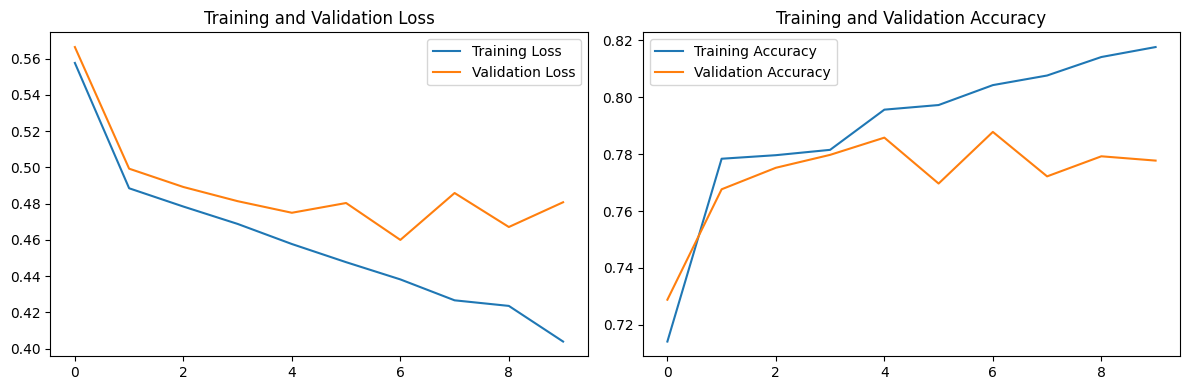

In [21]:
plt.figure(figsize=(12, 4))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## **5.2 Error Analysis**
Visualize misclassified images for error analysis.

In [22]:
# Get indices of misclassified images
img_mis = np.where(val_pred_classes != true_labels)[0]

---

# 6. Hyperparameter Tuning
Perform hyperparameter tuning to find the optimal configuration for the model.

In [24]:
!pip install keras-tuner

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

In [25]:
def build_model(hp):
    model = Sequential()
    
    # Convolutional layers
    model.add(Conv2D(hp.Int('input_units', min_value=32, max_value=64, step=32), (3, 3), activation='relu', input_shape=(IMG_WIDTH, IMG_HEIGHT, 3)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(hp.Int('n_layers', 1, 3)): 
        model.add(Conv2D(hp.Int(f'conv_{i}_units', min_value=32, max_value=64, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Fully connected layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 1e-4]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [26]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=3,
    executions_per_trial=1,
    directory='output',
    project_name='CNNCancerDetection')

tuner.search(train_gen, epochs=5, validation_data=val_gen)

Trial 3 Complete [00h 06m 12s]
val_accuracy: 0.7789999842643738

Best val_accuracy So Far: 0.7789999842643738
Total elapsed time: 00h 19m 27s


---

# 7. Results and Analysis

## **7.1 Visualization of Training**
Visualize change of loss and accuracy over epochs.

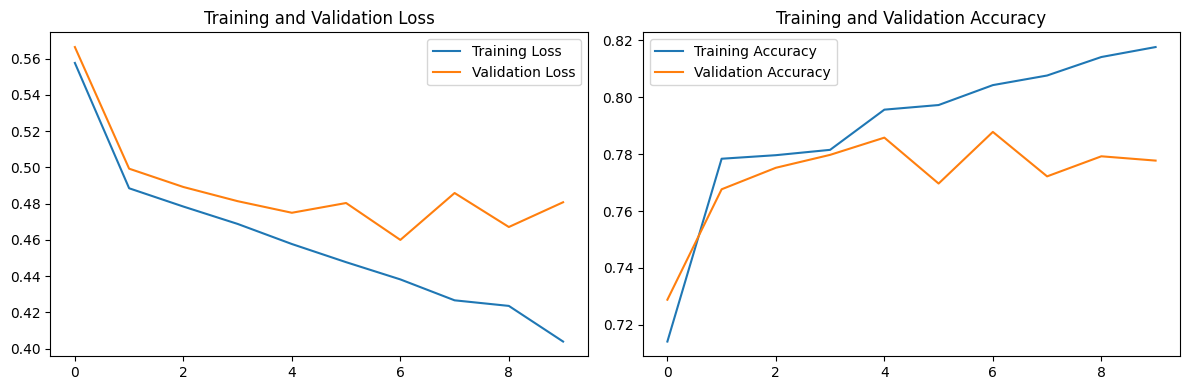

In [28]:
plt.figure(figsize=(12, 4))

# Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

# Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.show()

## **7.2 Conclusion**
After model training, evaluation, and optimization, the model achieved an accuracy of **0.78%.** The model performs fairly well but can be optimized and improved upon further. Future directions could include changing the number of epochs that were trained on, deeper architecture, or more advanced augmentation techniques. 